In [52]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import copy
from keras.models import load_model
from keras.models import Sequential
import math
from sklearn.cluster import DBSCAN

%load_ext autoreload
%autoreload 1
%aimport script_hard_example

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


FileNotFoundError: [Errno 2] No such file or directory: 'data_save_difficult_nofaces/'

In [10]:
# -------------------------------------------------
# Constant
SIZE_FILTER_X = 36
SIZE_FILTER_Y = 36
NB_ITERATION = 20

In [11]:
def load_model_keras(path_to_model):
    return load_model(path_to_model)

In [22]:
def compute_mean_rectangle(list_point, step_x, step_y):
    has_changed = True
    while(has_changed):
        has_changed = False
        temp_result = []
        list_indice = []
        for i in range(len(list_point)):
            Added_new_element = False
            for j in range(i+1, len(list_point)):
                if (math.fabs(list_point[i][0] - list_point[j][0]) <= 3*step_x and
                    math.fabs(list_point[i][1] - list_point[j][1]) <= 3*step_y and j not in list_indice):
                    
                    temp_result.append((int((list_point[i][0] + list_point[j][0])/2), int((list_point[i][1] + list_point[j][1])/2)))
                    list_indice.append(j)
                    Added_new_element = True
                    
            if Added_new_element == False and i not in list_indice:
                temp_result.append(list_point[i])
                
            has_changed = has_changed | Added_new_element
            
        list_point = copy.deepcopy(temp_result)
    
    return list_point
        

In [39]:
def search_visage(gray_image, size_filter_X, size_filter_Y, model):
    
    # Raise an exception, if we can't apply the fitlter
    width, height = gray_image.shape[0], gray_image.shape[1]
    
    if width < size_filter_Y and height < size_filter_X :
        raise Exception ("impossible to crop properly")
        
    if (size_filter_X/2) % 2 != 0 or (size_filter_Y/2) % 2 != 0:
        raise Exception ("All dimension of the filter should be pair")
    
    # loop on the image.
    fil_divi_2_X = int (size_filter_X/2)
    fil_divi_2_Y = int (size_filter_Y/2)
    step_x = int(fil_divi_2_X/3)
    step_y = int(fil_divi_2_Y/3)
    result = []
    listImgPos = []
    for y in range(fil_divi_2_X, height - fil_divi_2_X, step_x):
        for x in range(fil_divi_2_Y, width - fil_divi_2_Y, step_y):
            crop_img = gray_image[y - fil_divi_2_Y: y + fil_divi_2_Y, x - fil_divi_2_X : x + fil_divi_2_X]
            
            crop_imag_copy  = copy.deepcopy(crop_img)
            
            crop_img = np.array(crop_img)
            crop_img.resize((1,36,36,1))
            
            # print('LOG - ', model.predict(crop_img,verbose = 0)[0])
            if int(model.predict(crop_img,verbose = 0)[0][1] + 0.5) == 1:
            # if int(model.predict(crop_img,verbose = 0)[0] + 0.5) == 1:
                # print ("GET A VISAGE")
                result.append((x,y))
                listImgPos.append(crop_imag_copy)
    return compute_mean_rectangle(result, step_x, step_y), listImgPos

In [129]:
def draw_rectangle(img, cor_x, cor_y, size_filter_X, size_filter_Y ):
    # print("ADD RECTANGLE")
    fil_divi_2_X = int (size_filter_X/2)
    fil_divi_2_Y = int (size_filter_Y/2)
    cv2.rectangle(img, (cor_x - fil_divi_2_X, cor_y - fil_divi_2_Y), (cor_x + fil_divi_2_X, cor_y + fil_divi_2_Y), (0,255,0), 2)
    return img

In [33]:
def pyramid_search (path_image, size_filter_X, size_filter_Y, nb_iterations, model):
    # We get and tranform the image in gray.
    img_search = cv2.imread(path_image)
    gray_image = cv2.cvtColor(img_search, cv2.COLOR_BGR2GRAY)
    gray_imag_rect  = copy.deepcopy(gray_image)
    
    # Make the reduction.
    # --> search
    height, width = gray_image.shape
    nbPixelToReduceX = int(int(width  - size_filter_X) / (nb_iterations-1))
    nbPixelToReduceY = int(int(height - size_filter_Y) / (nb_iterations-1))
    
    results = []
    for ite in range(nb_iterations) :
        
        height, width = gray_image.shape
        
        if(ite == nb_iterations-1):
            gray_image = cv2.resize(gray_image, (size_filter_X, size_filter_Y)) # Last iteration
            size_filter_X_new = width - nbPixelToReduceX
            size_filter_Y_new = height - nbPixelToReduceY
            height, width = gray_image.shape
        elif(ite == 0):
            size_filter_X_new = size_filter_X - nbPixelToReduceX
            size_filter_Y_new = size_filter_Y - nbPixelToReduceY
        else :
            gray_image = cv2.resize(gray_image, (width - nbPixelToReduceX, height - nbPixelToReduceY))   
        
        gray_imag_rect_copy  = copy.deepcopy(gray_image)
            
        # we get all square that seems to be a visage.
        result, listImgPos = search_visage(gray_image, size_filter_X, size_filter_Y, model)
        
        size_filter_X_new = nbPixelToReduceX + size_filter_X_new
        size_filter_Y_new = nbPixelToReduceY + size_filter_Y_new
        
        results += result
        # draw red rectangle.
        for x, y in result:
            print('(x, y) = (', x, ', ', y, ') on image : ', gray_image.shape )
            gray_imag_rect = draw_rectangle(gray_image, x, y, size_filter_X, size_filter_Y)
        
        
        ## Display positives images
        #for l in listImgPos :
        #    plt.figure()
        #    plt.imshow(l)
            
        ## Display initial image with reds rectangles. 
        if(result == []) :
            plt.figure()
            plt.imshow(gray_image)
        else :
            plt.figure()
            plt.imshow(gray_imag_rect)
        
        # Remove rectangle before next iteration.
        gray_image = gray_imag_rect_copy       
        
    return gray_imag_rect

In [132]:
def pyramid_search_all (path_image, size_filter_X, size_filter_Y, nb_iterations, model):
    # We get and tranform the image in gray.
    img_search = cv2.imread(path_image)
    gray_image = cv2.cvtColor(img_search, cv2.COLOR_BGR2GRAY)
    gray_imag_rect  = copy.deepcopy(gray_image)
    orig_imag = copy.deepcopy(gray_image)
    origin_height, origin_width = orig_imag.shape
    # Make the reduction.
    # --> search
    height, width = gray_image.shape
    nbPixelToReduceX = int(int(width  - size_filter_X) / (nb_iterations-1))
    nbPixelToReduceY = int(int(height - size_filter_Y) / (nb_iterations-1))
    
    results = []
    for ite in range(nb_iterations) :
        
        height, width = gray_image.shape
        
        if(ite == nb_iterations-1):
            gray_image = cv2.resize(gray_image, (size_filter_X, size_filter_Y)) # Last iteration
            size_filter_X_new = width - nbPixelToReduceX
            size_filter_Y_new = height - nbPixelToReduceY
            height, width = gray_image.shape
        elif(ite == 0):
            size_filter_X_new = size_filter_X - nbPixelToReduceX
            size_filter_Y_new = size_filter_Y - nbPixelToReduceY
        else :
            gray_image = cv2.resize(gray_image, (width - nbPixelToReduceX, height - nbPixelToReduceY))   
        
        gray_imag_rect_copy  = copy.deepcopy(gray_image)
            
        # we get all square that seems to be a visage.
        result, listImgPos = search_visage(gray_image, size_filter_X, size_filter_Y, model)
        
        size_filter_X_new = nbPixelToReduceX + size_filter_X_new
        size_filter_Y_new = nbPixelToReduceY + size_filter_Y_new
        
        nh, nw = gray_image.shape
        w = origin_width/nw
        h = origin_height/nh
        # draw red rectangle.
        for x, y in result:
            results.append((int(x*w), int(y*h), int(size_filter_X*w), int(size_filter_Y*h)))
    
    
        
    return orig_imag, results

In [133]:
def draw_rectangles_all(orig_imag, results) :
    # draw red rectangle.
    for x, y, w, h in results:
        gray_imag_rect = draw_rectangle(orig_imag, x, y, w, h)

    ## Display initial image with reds rectangles. 
    if(results == []) :
        plt.figure()
        plt.imshow(orig_imag)
    else :
        plt.figure()
        plt.imshow(gray_imag_rect)
   

In [134]:
model = load_model_keras('model_n.h5')
img_org, res = pyramid_search_all('groupFaces.jpg', SIZE_FILTER_X, SIZE_FILTER_Y, NB_ITERATION, model)
img = copy.deepcopy(img_org)

ValueError: too many values to unpack (expected 2)

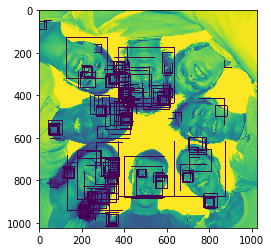

In [135]:
draw_rectangles_all(img, res)

In [125]:
def merge_rect(rectangles, img_w, img_h) :
    X =[]
    nb = len(rectangles)
    for x, y, w, h in rectangles :
        X.append([x, y])
    eps = (max([img_w, img_h]))*0.1
    db = DBSCAN(eps=eps, min_samples=5).fit(X)
    
    labels = db.labels_
    print(labels)
    clusters = {}
    for i in range(0, len(labels)) : 
        if labels[i] != -1 :
            if labels[i] in clusters :
                if rectangles[i][2] > clusters[labels[i]][2] :
                    clusters[labels[i]] = rectangles[i]
            else :
                clusters[labels[i]] = rectangles[i]
    results = []
    for c in clusters :
        results.append(clusters[c])
    return results
    
img_h, img_w = img.shape
results = merge_rect(res, img_w, img_h)
results

[-1 -1  0  0 -1  0  1  0  0  0  0  0  0  0  2  3  3  3  3  4  4  5  3  6
  3  3  3  0  0  0  0  0  0  0  2  5  3  3  3  4  5  4  3  6  3  3  0  0
  0  0  0  0  0  0  2  3  4  3  5  3  3  6  3  3  0  1  0  0  0  0  0  0
  2  5  3  3  3  4  5  3  6  3  3  0  0  0  0  0  0  0  0  0  0  2  3  3
  5  6  3  3  0  0  1  0  0  0  0  0 -1  0  2  5  3  3  4  5  3  3  6  3
  3  0  1  0  0  0  0  0  0  0  0  2  3  3  5  3  4  3  6  3  3  0  1  0
  0  0  0 -1  0  2  5  3  3  5  4  3  3  0  1  0  0  0  0  0  0  0  3  4
  3  6  3  0  0  0  0  0  0  2  5  3  3  3  6  3  3  0  0  1  0  0  0  0
  5  3  3  3  1  0  0  0  0  5  3  3  0  0  0  0  0  3  3  0  0  0  3  5
  0  0  0 -1  3  3  5  4  3  0  0  3  4  1  0  4  3  0  4  5  3]


[(504, 307, 263, 263),
 (224, 224, 192, 192),
 (77, 552, 66, 66),
 (263, 811, 263, 263),
 (504, 746, 263, 263),
 (746, 746, 263, 263),
 (806, 895, 66, 66)]

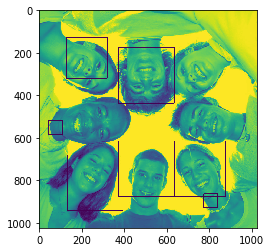

In [138]:
img_c = copy.deepcopy(img_org)
draw_rectangles_all(img_c, results)

<h1>HARD Example</h1>

In [17]:
def pyramid_search_difficult (path_image, size_filter_X, size_filter_Y, nb_iterations, model, threshold):
    # We get and tranform the image in gray.
    img_search = cv2.imread(path_image)
    gray_image = cv2.cvtColor(img_search, cv2.COLOR_BGR2GRAY)
    gray_imag_rect  = copy.deepcopy(gray_image)
    
    # Make the reduction.
    # --> search
    height, width = gray_image.shape
    nbPixelToReduceX = int((width  - size_filter_X) / (nb_iterations -1) )
    nbPixelToReduceY = int((height - size_filter_Y) / (nb_iterations -1) ) 
    
    list_reponse = []
    for ite in range(nb_iterations) :
        
        height, width = gray_image.shape
        
        if(ite == nb_iterations-1):
            gray_image = cv2.resize(gray_image, (size_filter_X, size_filter_Y)) # Last iteration
            size_filter_X_new = width - nbPixelToReduceX
            size_filter_Y_new = height - nbPixelToReduceY
            height, width = gray_image.shape
        elif(ite == 0):
            size_filter_X_new = size_filter_X - nbPixelToReduceX
            size_filter_Y_new = size_filter_Y - nbPixelToReduceY
        else :
            gray_image = cv2.resize(gray_image, (width - nbPixelToReduceX, height - nbPixelToReduceY))   
        
        gray_imag_rect_copy  = copy.deepcopy(gray_image)
        
        # we get a list of all visage.
        list_reponse = list_reponse + search_visage(gray_image, size_filter_X, size_filter_Y, model, threshold)
        
    return list_reponse

In [18]:
def search_visage(gray_image, size_filter_X, size_filter_Y, model, threshold):
    
    # Raise an exception, if we can't apply the fitlter
    width, height = gray_image.shape[0], gray_image.shape[1]
    
    if width < size_filter_Y and height < size_filter_X :
        raise Exception ("impossible to crop properly")
        
    if (size_filter_X/2) % 2 != 0 or (size_filter_Y/2) % 2 != 0:
        raise Exception ("All dimension of the filter should be pair")
    
    # loop on the image.
    fil_divi_2_X = int (size_filter_X/2)
    fil_divi_2_Y = int (size_filter_Y/2)
    step_x = int(fil_divi_2_X/3)
    step_y = int(fil_divi_2_Y/3)
    listImgPos = []
    for y in range(fil_divi_2_X, height - fil_divi_2_X, step_x):
        for x in range(fil_divi_2_Y, width - fil_divi_2_Y, step_y):
            crop_img = gray_image[y - fil_divi_2_Y: y + fil_divi_2_Y, x - fil_divi_2_X : x + fil_divi_2_X]
            
            crop_imag_copy  = copy.deepcopy(crop_img)
            crop_img = np.array(crop_img)
            crop_img.resize((1,36,36,1))
            
            if int(model.predict(crop_img,verbose = 0)[0] + threshold) == 1:
                listImgPos.append(crop_imag_copy)

    return listImgPos

In [19]:
model = load_model_keras('my_model.h5')
path_repo = "data_difficult_faces/0/"
path_save = "data_save_difficult_no_faces/"
def find_and_save_difficult_images(path_repo, path_save, threshold, model, indice):
    list_image = []
    # get the image.
    for index, filename in enumerate(os.listdir(path_repo)):
        if filename == ".DS_Store":
            continue
        list_difficult_faces =  pyramid_search_difficult(os.path.join(path_repo, filename), SIZE_FILTER_X, SIZE_FILTER_Y, NB_ITERATION, model, threshold)
        print("Traite l'image : "+ str(index) + " find : "+ str(len (list_difficult_faces)))
        list_image +=  list_difficult_faces
    
    max_indice = 0    
    for index, image in enumerate(list_image):
        width, height = image.shape[0], image.shape[1]
        max_indice = indice + index
        if width == 36 and height == 36:
            print(os.path.join(path_save, str(indice + index) + ".jpg"))
            cv2.imwrite(os.path.join(path_save, str(index) + ".jpg"), image)  
    
    return max_indice

In [15]:
THRESHOLD = 0.7
def update_model (path_save, threshold):
    path_repo = "data_difficult_faces/"
    indice = 0
    threshold = 0.2
    model = None
    
    lenght_repo = 0
    if ".DS_Store" in os.listdir("data_difficult_faces/"):
        lenght_repo = len(os.listdir("data_difficult_faces/"))-1
    else:
        lenght_repo = len(os.listdir("data_difficult_faces/"))-1
        
    for ite in range(lenght_repo):
        print ("iteration : " + str(ite) + " threshold : "+  str(threshold))
        cur_path_rep = path_repo + str(ite) + "/"
        print(cur_path_rep)
        model = script_hard_example.get_model(1)
        indice += find_and_save_difficult_images(cur_path_rep, path_save, threshold, model, indice)
        threshold = threshold * THRESHOLD
    
    model = load_model_keras('my_model.h5')
    model.save('my_model.h5')

update_model(path_save, 0.2)